# 04 Makemore - Activations, Gradients and Batchnorm

## setup
Tidy up of working code in preparation for diving into the internals of MLPS. Investigationg the forward pass activation, backward pass gradients and some gotchas.

In [20]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt, random

In [16]:
words = open("../names.txt").read().splitlines()

In [17]:
chars = sorted(list(set(''.join(words))) + ['.'])
itos = {idx: ch for idx, ch in enumerate(chars)}
stoi = {v:k for k, v in itos.items()}

In [147]:
def build_dataset(words, block_size=3):
    # build the full dataset
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

def split_dataset(X,Y):
    random.seed(42); 
    random.shuffle(words) # randomly shuffle words
    
    n1 = int(0.8 * X.shape[0])
    n2 = int(0.9 * X.shape[0])
    Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0)
    Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)
    print(Xtr.shape, Ytr.shape)
    print(Xdev.shape, Ydev.shape)
    print(Xts.shape, Yts.shape)
    return Xtr, Ytr, Xdev, Ydev, Xts, Yts


@torch.no_grad() # this decorator disables gradient tracking - avoid bookkeeping for torch which is more efficient
def split_loss(split):
    # calculates the loss for datasets
    x,y = {"train": (Xtr, Ytr),"val": (Xdev, Ydev),"test": (Xts, Yts)}[split]
        
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

In [61]:
# setup hyperparameters 
block_size = 3 # the number of input characters
vocab_size = 27 # distinct range of input characters
n_embed = 10 # the dimensionality of the character embedding space
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# build test, dev and train datasets
Xtr, Ytr, Xdev, Ydev, Xts, Yts = split_dataset(*build_dataset(words, block_size))

torch.Size([182516, 3]) torch.Size([182516])
torch.Size([22815, 3]) torch.Size([22815])
torch.Size([22815, 3]) torch.Size([22815])


In [181]:
# initalise the nn 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden,27),                    generator=g)
b2 = torch.randn(vocab_size,                       generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

11897


In [182]:
# training the model
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    break # used to break after 1 iteration to show state of the model after 1 iteration, where loss can be ~28.

      0/ 200000: 28.5922


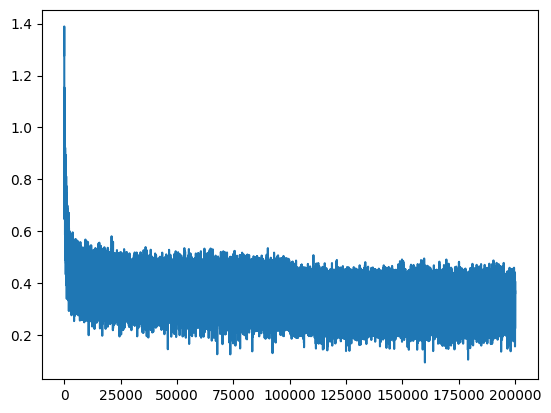

In [174]:
plt.plot(lossi);

In [175]:
# loss with random initialisation:
split_loss('train') # 2.136
split_loss('val') # 2.184

train 2.135777711868286
val 2.183779239654541


In [176]:
# model sampling
for _ in range(20):
    context = [0] * block_size
    word = []
    while True:
        
        emb = C[context]
        embcat = emb.view(1,-1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if itos[ix] == '.':
            break
        word.append(itos[ix])
        context = context[1:] + [ix]
    print(''.join(word))

kaden
dailandiconnix
adanson
mariggeera
orrine
chuwe
elivo
got
baylen
mayson
len
ligher
yana
rainon
yay
del
tauna
aleagalia
egen
pisrenia


## Investigate and fixing the inital loss
First step has very high loss (27.8), we'd like much lower. We'd want initial loss to only uniform distribution 1/27.0, so loss is 3.2958. If the model is confidently wrong the loss is much higher. We want to start the training with a lower loss, and initials the model's weights, we can do this by multiplying the weights and bias by a small or zero to make the loss closer to 0 and more uniform.

In [160]:
# we want the loss to be uniform so the loss should initially be: 
-torch.tensor(1/27.0).log()
# but we get a very messed up, and the model is very confidently wrong

tensor(3.2958)

In [162]:
# 4d example of the issue:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [179]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss # can be very high loss

(tensor([-2.0687, -2.2561,  9.4957, 22.7108]),
 tensor([1.7314e-11, 1.4356e-11, 1.8229e-06, 1.0000e+00]),
 tensor(13.2151))

In [183]:
# run the code above and break afrer the first iteration and look at the first item in the minibatch. Look at the logits
# where the loss is very high ~28
logits[0]

tensor([ 20.4446, -13.4149, -25.8656,   6.3718,  11.2841,  28.9982, -25.0925,
        -15.1387,  23.3197,   2.4465,  10.4902, -12.7129,  -1.1194,  -4.8172,
         -0.3411, -28.8215, -21.4922, -16.8877, -20.7713,   7.5535,  -5.8498,
         -0.0803,  -4.9603,  -3.6459,  -0.7197,  -0.7587, -18.2604],
       grad_fn=<SelectBackward0>)

In [184]:
# initalise the nn with better initialised loss: 
# not zero for W2, as need entropy, for symmetry breaking
# this stops neurons behaving in the same way, so each neuron learns different aspects of the data. if they were all 0 
# all neurons learn the  same feature.
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden,27),                    generator=g) * 0.01  # not zero!
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

11897


In [185]:
# training the model which has been initalised more optimially
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())


      0/ 200000: 3.3195
  10000/ 200000: 1.8446
  20000/ 200000: 1.7726
  30000/ 200000: 2.1825
  40000/ 200000: 1.9668
  50000/ 200000: 2.3464
  60000/ 200000: 1.9107
  70000/ 200000: 2.3133
  80000/ 200000: 1.9851
  90000/ 200000: 2.2129
 100000/ 200000: 2.2940
 110000/ 200000: 2.4607
 120000/ 200000: 2.0687
 130000/ 200000: 2.1357
 140000/ 200000: 2.1598
 150000/ 200000: 2.4539
 160000/ 200000: 2.3531
 170000/ 200000: 2.3775
 180000/ 200000: 2.2480
 190000/ 200000: 2.0948


train 2.069873094558716
val 2.147005081176758


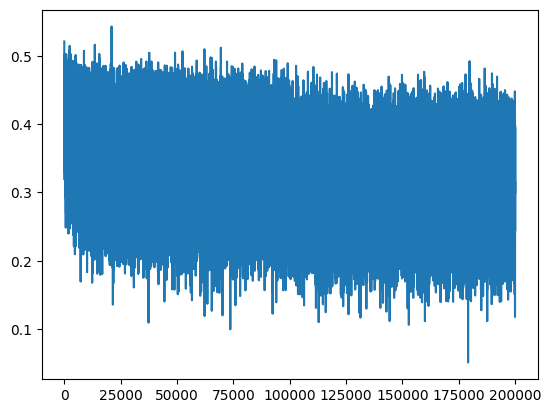

In [186]:
# don't waste iterations (1000's) just squashing down the weights, and spend more cycles optimising the nn.
# the starting loss is 3.3195. and loss is better:
split_loss('train') # 2.070 compared to 2.136 before
split_loss('val') # 2.147 compared to 2.184 before
plt.plot(lossi);

## Fixing the saturated tanh

In [190]:
# looking at h:
h.shape, h

(torch.Size([32, 200]),
 tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000,  0.9999,  0.9999],
         [-1.0000,  0.9719, -0.0251,  ...,  0.9101,  0.9999,  0.9999],
         [-0.3260, -0.9999, -0.9993,  ...,  1.0000, -0.6485, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000,  0.9999,  0.9999],
         [-1.0000,  0.9808, -0.1404,  ..., -0.9967, -1.0000,  0.9941],
         [-0.9699,  0.6070,  1.0000,  ..., -1.0000,  0.9995,  1.0000]],
        grad_fn=<TanhBackward0>))

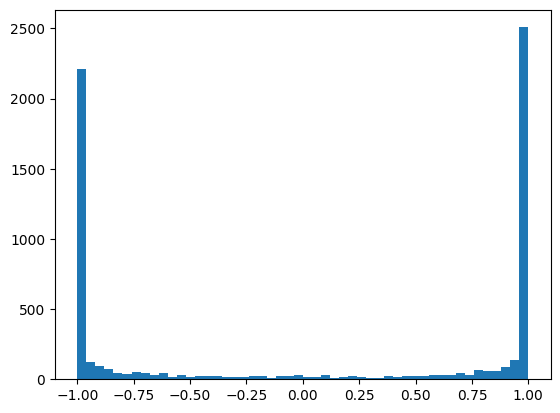

In [196]:
# look at histogram of the distribution in 50 buckets. This shows high humber of values at -1 and 1:
plt.hist(h.view(-1).tolist(), 50);

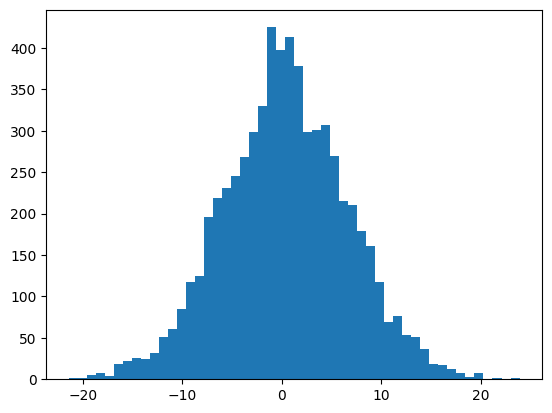

In [197]:
# similarly for hpreact, input into the hidden layer tanh:
plt.hist(hpreact.view(-1).tolist(), 50);

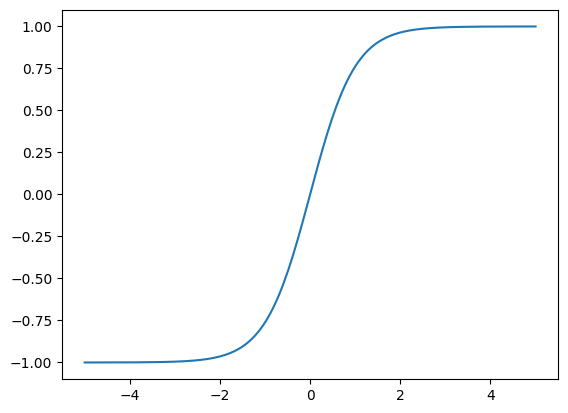

In [213]:
# the hidden preactivations, hpreact, when +/- 2 produce nearly saturated tanh values (see h) jwhere gradient is nearly 0:
x = torch.linspace(-5,5,steps =200)
# x
plt.plot(x, torch.tanh(x));
